In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import os
import copy

import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
plt.ion()

import warnings
warnings.filterwarnings('ignore')

In [2]:
#data transformations
data_transforms = {
    'train': transforms.Compose([
      transforms.Resize((256,256)),
      transforms.ToTensor(),
      #normalize the images, set the mean and std
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
      transforms.Resize((256,256)),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
#load train and val data
data_dir = '../input/ant-and-bee/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size = 4,
                                              shuffle = True, num_workers = 4)
               for x in ['train', 'val']}

In [4]:
#set gpu device to store the tensors, if none use gpu
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
classes = image_datasets['train'].classes
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(dataset_sizes)
print(device)

# split data for traning data (80%) and testing data (20%)
train_size = int(0.8 * len(image_datasets['train']))
test_size = len(image_datasets['train']) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(image_datasets['train'], [train_size, test_size])


#load train and val data
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size = 4,
                                              shuffle = True, num_workers = 4)
               for x in ['train', 'val']}
print(len(dataloaders['train']))
print(len(dataloaders['val']))

#visualize the data
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

{'train': 244, 'val': 153}
cuda:0
61
39


In [5]:
#function to show images
def imshow(inp, title = None):
  inp = inp.numpy().transpose((1,2,0))
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  inp = std + inp * mean
  inp = np.clip(inp,0,1)
  plt.figure(figsize = (14,5))
  plt.imshow(inp);
  if title is not None:
    plt.title(title);


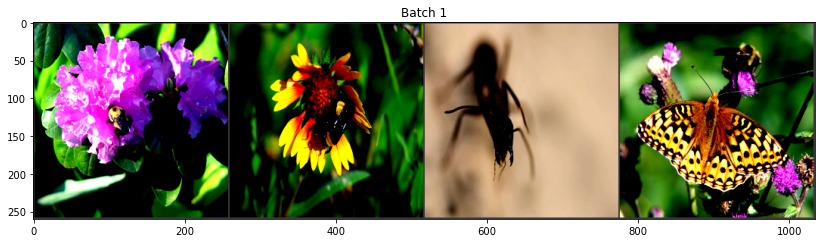

In [6]:
#show sample batch of images
images, labels = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(images)

imshow(out, 'Batch 1')

In [7]:
#create a function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):

  since = time.time()

  #create a copy of current model
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  #run training
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    # print('=' *20)

    for phase in ['train', 'val']:
      #set the model
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0
    
      #iterate through the data
      for inputs, labels in dataloaders[phase]:
        #get the input and labels then point them to gpu memory
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #zero the gradients
        optimizer.zero_grad()
        #track the history if training
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            #get the new gradients
            loss.backward()
            #update the weights
            optimizer.step()
        
        #trach the loss and accuracy
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
      
      if phase == 'train':
        scheduler.step()
    
      #compute mean loss & accuracy 
      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
      #           phase, epoch_loss, epoch_acc))
      
      #get the best model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    # print()
  
  #compute time elapsed
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best Validation Accuracy: {}'.format(best_acc))
  
  #set the best model then return it
  model.load_state_dict(best_model_wts)
  return model


In [8]:
#Transfer Learning ResNet
model_conv = models.resnet18(pretrained=True)

#freeze the pre-trained weights on convolutional layer
for param in model_conv.parameters():
  param.requires_grad = False

#classifier
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

#set the gpu
model_conv = model_conv.to(device)
# #set sgd as optimizer & get a loss function
criterion_conv = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [9]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define custom loss functions as nn.Module classes
class MRSQE(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true):
        y_pred = F.softmax(y_pred, dim=1)
        y_true = F.one_hot(y_true, num_classes=y_pred.size(1)).float()
        return torch.mean((y_true - y_pred) ** 2)

class MAE(nn.Module):
    def __init__(self):
        super().__init__()
    
    
    def forward(self, y_pred, y_true):
        y_pred = F.softmax(y_pred, dim=1)
        y_true = F.one_hot(y_true, num_classes=y_pred.size(1)).float()
        return torch.mean(torch.abs(y_true - y_pred))

class MAPE(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true):
        y_pred = F.softmax(y_pred, dim=1)
        y_true = F.one_hot(y_true, num_classes=y_pred.size(1)).float()
        return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100
   
class RMSE(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true):
        y_pred = F.softmax(y_pred, dim=1)
        y_true = F.one_hot(y_true, num_classes=y_pred.size(1)).float()
        return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

criterion1 = nn.CrossEntropyLoss()
criterion2 = MRSQE()
criterion3 = MAE()
criterion4 = MAPE()
criterion5 = RMSE()

# Load the pre-trained model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)





In [10]:
import time
# Assuming train_model is a function defined elsewhere in the notebook
model_ft = train_model(model_ft, criterion1, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
Epoch 1/24
Epoch 2/24
Epoch 3/24
Epoch 4/24
Epoch 5/24
Epoch 6/24
Epoch 7/24
Epoch 8/24
Epoch 9/24
Epoch 10/24
Epoch 11/24
Epoch 12/24
Epoch 13/24
Epoch 14/24
Epoch 15/24
Epoch 16/24
Epoch 17/24
Epoch 18/24
Epoch 19/24
Epoch 20/24
Epoch 21/24
Epoch 22/24
Epoch 23/24
Epoch 24/24
Training complete in 0m 57s
Best Validation Accuracy: 0.9281045751633987


In [11]:
model_ft = train_model(model_ft, criterion2, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
Epoch 1/24
Epoch 2/24
Epoch 3/24
Epoch 4/24
Epoch 5/24
Epoch 6/24
Epoch 7/24
Epoch 8/24
Epoch 9/24
Epoch 10/24
Epoch 11/24
Epoch 12/24
Epoch 13/24
Epoch 14/24
Epoch 15/24
Epoch 16/24
Epoch 17/24
Epoch 18/24
Epoch 19/24
Epoch 20/24
Epoch 21/24
Epoch 22/24
Epoch 23/24
Epoch 24/24
Training complete in 0m 57s
Best Validation Accuracy: 0.9215686274509804


In [12]:
model_ft = train_model(model_ft, criterion3, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
Epoch 1/24
Epoch 2/24
Epoch 3/24
Epoch 4/24
Epoch 5/24
Epoch 6/24
Epoch 7/24
Epoch 8/24
Epoch 9/24
Epoch 10/24
Epoch 11/24
Epoch 12/24
Epoch 13/24
Epoch 14/24
Epoch 15/24
Epoch 16/24
Epoch 17/24
Epoch 18/24
Epoch 19/24
Epoch 20/24
Epoch 21/24
Epoch 22/24
Epoch 23/24
Epoch 24/24
Training complete in 0m 57s
Best Validation Accuracy: 0.9215686274509804


In [13]:
model_ft = train_model(model_ft, criterion4, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
Epoch 1/24
Epoch 2/24
Epoch 3/24
Epoch 4/24
Epoch 5/24
Epoch 6/24
Epoch 7/24
Epoch 8/24
Epoch 9/24
Epoch 10/24
Epoch 11/24
Epoch 12/24
Epoch 13/24
Epoch 14/24
Epoch 15/24
Epoch 16/24
Epoch 17/24
Epoch 18/24
Epoch 19/24
Epoch 20/24
Epoch 21/24
Epoch 22/24
Epoch 23/24
Epoch 24/24
Training complete in 0m 56s
Best Validation Accuracy: 0.4575163398692811


In [14]:
model_ft = train_model(model_ft, criterion5, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
Epoch 1/24
Epoch 2/24
Epoch 3/24
Epoch 4/24
Epoch 5/24
Epoch 6/24
Epoch 7/24
Epoch 8/24
Epoch 9/24
Epoch 10/24
Epoch 11/24
Epoch 12/24
Epoch 13/24
Epoch 14/24
Epoch 15/24
Epoch 16/24
Epoch 17/24
Epoch 18/24
Epoch 19/24
Epoch 20/24
Epoch 21/24
Epoch 22/24
Epoch 23/24
Epoch 24/24
Training complete in 0m 57s
Best Validation Accuracy: 0.4575163398692811


In [15]:
# Install scikit-learn if not already installed
%pip install scikit-learn

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define the test dataset and dataloader
# data_dir = ''  # Replace with the path to your data directory
test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# test_dataset = datasets.ImageFolder(root=f'{data_dir}/test', transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Get predictions for the test set
y_true = []
y_pred = []

model_conv.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_conv(inputs)
        _, predictions = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate metrics
conf_matrix = confusion_matrix(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred, average='binary')
specificity = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
f1 = f1_score(y_true, y_pred, average='binary')

print('Confusion Matrix:')
print(conf_matrix)
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'F1-score: {f1:.4f}')

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Confusion Matrix:
[[21  6]
 [20  2]]
Sensitivity (Recall): 0.0909
Specificity: 0.7778
F1-score: 0.1333


In [16]:
import time
#train the model
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
model_conv = train_model(model_conv, criterion_conv, optimizer_conv, exp_lr_scheduler)

Epoch 0/24
Epoch 1/24
Epoch 2/24
Epoch 3/24
Epoch 4/24
Epoch 5/24
Epoch 6/24
Epoch 7/24
Epoch 8/24
Epoch 9/24
Epoch 10/24
Epoch 11/24
Epoch 12/24
Epoch 13/24
Epoch 14/24
Epoch 15/24
Epoch 16/24
Epoch 17/24
Epoch 18/24
Epoch 19/24
Epoch 20/24
Epoch 21/24
Epoch 22/24
Epoch 23/24
Epoch 24/24
Training complete in 0m 48s
Best Validation Accuracy: 0.954248366013072


In [17]:
#get a sample image for testing
images, labels = next(iter(dataloaders['val']))
samp_image = images[0]

In [18]:
model_conv(samp_image.view(1,3,256,256).to(device))

tensor([[-3.1873,  2.2086]], device='cuda:0', grad_fn=<AddmmBackward>)

In [19]:
#function to show images
def imshow(inp, title = None):
  #copy the image to cpu
  inp = inp.to('cpu')
  inp = inp.numpy().transpose((1,2,0))
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  inp = std + inp * mean
  inp = np.clip(inp,0,1)
  plt.figure(figsize = (14,5))
  plt.imshow(inp);
  if title is not None:
    plt.title(title, fontsize=20);

def predict(img, model):
    pred_img = img.view(1,3,256,256).to(device)
    pred = torch.max(model(pred_img),1)[1]
    imshow(img, classes[pred].capitalize())


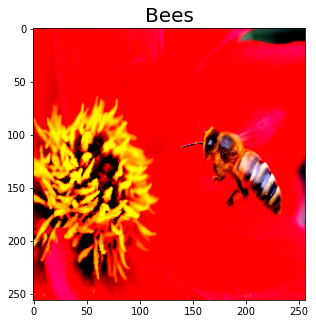

In [20]:
#show prediction
predict(samp_image, model_conv)